In [2]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
import mapclassify as mc
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import contextily as ctx
%matplotlib inline
from pyproj import Transformer, CRS, Proj
from shapely.geometry import shape, Point, Polygon
import numpy as np
import shapely.speedups as speedups
speedups.enable()

/home/sagnik/miniconda3/envs/workshop_env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
OUTPUT = Path.cwd().parents[0] / "Output"
df = pd.read_csv(Path.cwd().parents[0] /"CSV"/"HLL"/"latlng_to_geohash.csv")
gdf = gpd.GeoDataFrame(df,geometry =gpd.points_from_xy(df.longitude_3,df.latitude_3),crs ="EPSG:4326")
gdf

,latitude_3,longitude_3,usercount,postcount,hashtags,geometry
0,51.328125,-0.703125,1225,2219,muslimban,POINT (-0.70312 51.32812)
1,51.328125,-0.703125,1129,2135,refugees,POINT (-0.70312 51.32812)
2,51.328125,-0.703125,953,1974,refugeeswelcome,POINT (-0.70312 51.32812)
3,48.515625,2.109375,917,2831,migrants,POINT (2.10938 48.51562)
4,51.328125,-0.703125,883,1704,immigration,POINT (-0.70312 51.32812)
...,...,...,...,...,...,...
143243,41.484375,16.171875,1,1,essereumani,POINT (16.17188 41.48438)
143244,41.484375,16.171875,1,1,facciadiculo,POINT (16.17188 41.48438)
143245,41.484375,16.171875,1,1,facebook,POINT (16.17188 41.48438)
143246,41.484375,16.171875,1,1,falsita,POINT (16.17188 41.48438)


In [9]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
eu = gpd.read_file(Path.cwd().parents[0] / "Europe_coastline_shapefile"/ "eu_shp_4326.shp")
eu.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,142257519,Europe,Russia,RUS,3745000.0,"MULTIPOLYGON (((20.89224 54.31252, 19.66064 54..."
1,5320045,Europe,Norway,-99,364700.0,"MULTIPOLYGON (((25.68921 69.09211, 24.73568 68..."
2,67106161,Europe,France,-99,2699000.0,"MULTIPOLYGON (((6.65823 49.20196, 8.09928 49.0..."
3,8299706,Asia,Israel,ISR,297000.0,"POLYGON ((34.92260 29.50133, 34.82324 29.76108..."
4,6229794,Asia,Lebanon,LBN,85160.0,"POLYGON ((35.12605 33.09090, 35.24322 33.35887..."


<AxesSubplot:>

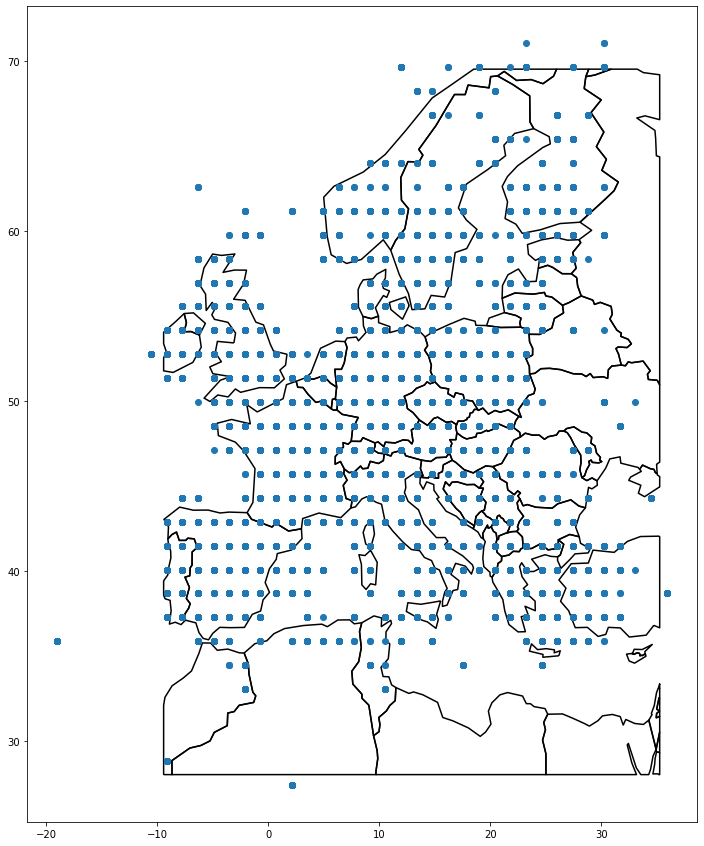

In [7]:
fig,ax = plt.subplots(1,figsize=(15,15))
eu.boundary.plot(ax=ax,
                 edgecolor = 'black')
gdf.plot(ax=ax,
         zorder = 2)

<AxesSubplot:title={'center':'FR'}>

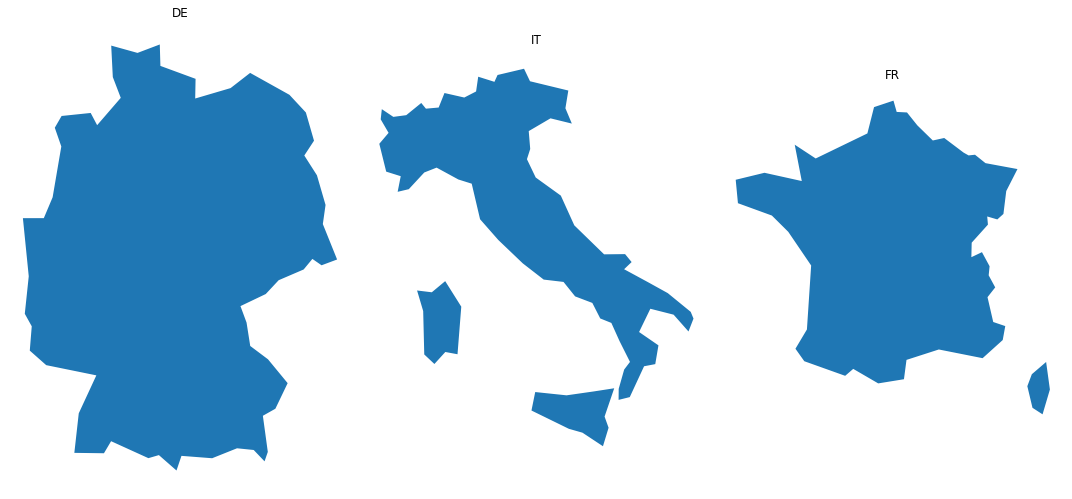

In [11]:
de = eu[eu['name'] == "Germany"]
fr = eu[eu['name'] == "France"]
it = eu[eu['name'] == "Italy"]

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (15,10))

for ax in (ax1,ax2,ax3):
    ax.set_axis_off()
    
plt.tight_layout()

ax1.title.set_text('DE')
ax2.title.set_text('IT')
ax3.title.set_text('FR')

de.plot(ax=ax1)
it.plot(ax=ax2)
fr.plot(ax=ax3)

In [12]:
#create grids

GRID_SIZE_METERS = 100000 
                        
# target projection: Web Mercator (epsg code)
EPSG_CODE = 3857
# note: Mollweide defined by _esri_
# in epsg.io's database
CRS_PROJ = f"epsg:{EPSG_CODE}"
# Input projection WGS 84
CRS_WGS = "epsg:4326"

# define Transformer ahead of time
# with xy-order of coordinates
PROJ_TRANSFORMER = Transformer.from_crs(
    CRS_WGS, CRS_PROJ, always_xy=True)

# also define reverse projection
PROJ_TRANSFORMER_BACK = Transformer.from_crs(
    CRS_PROJ, CRS_WGS, always_xy=True)

In [13]:
de.total_bounds

array([ 5.98865807, 47.3024877 , 15.01699588, 54.98310415])

In [52]:
(5.98865807+15.01699588)/2

10.502826975

In [14]:
XMIN = PROJ_TRANSFORMER.transform(5.98865807, 10.502826975)[0]
XMAX = PROJ_TRANSFORMER.transform(15.01699588, 10.502826975)[0]
YMAX = PROJ_TRANSFORMER.transform(51.142795925, 54.98310415)[1]
YMIN = PROJ_TRANSFORMER.transform(51.142795925, 47.3024877)[1]

In [15]:
print(f'Projected bounds: {[XMIN, YMIN, XMAX, YMAX]}')

Projected bounds: [666654.3668874284, 5991588.288677101, 1671684.334606287, 7358587.663334562]


In [16]:
width = GRID_SIZE_METERS
length = GRID_SIZE_METERS
cols = list(range(int(np.floor(XMIN)), int(np.ceil(XMAX)), width))
rows = list(range(int(np.floor(YMIN)), int(np.ceil(YMAX)), length))
rows.reverse()

polygons = []
for x in cols:
     for y in rows:
            # combine to tuple: (x,y, poly)
            # and append to list
            polygons.append(
                (x, y,
                 Polygon([
                     (x, y),
                     (x+width, y),
                     (x+width, y-length),
                     (x, y-length)])))
grid = pd.DataFrame(polygons)
    # name columns
col_labels=['xbin', 'ybin', 'bin_poly']
grid.columns = col_labels
    # use x and y as index columns
grid.set_index(['xbin', 'ybin'], inplace=True)
grid.head()

bin_poly
xbin   ybin                                                      
666654 7291588  POLYGON ((666654 7291588, 766654 7291588, 7666...
       7191588  POLYGON ((666654 7191588, 766654 7191588, 7666...
       7091588  POLYGON ((666654 7091588, 766654 7091588, 7666...
       6991588  POLYGON ((666654 6991588, 766654 6991588, 7666...
       6891588  POLYGON ((666654 6891588, 766654 6891588, 7666...

In [17]:
grid = gpd.GeoDataFrame(
        grid.drop(
            columns=["bin_poly"]),
            geometry=grid.bin_poly)
grid.crs = CRS_PROJ

In [18]:
de = de.to_crs(epsg =3857)
de.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

CPU times: user 684 ms, sys: 283 ms, total: 967 ms
Wall time: 475 ms


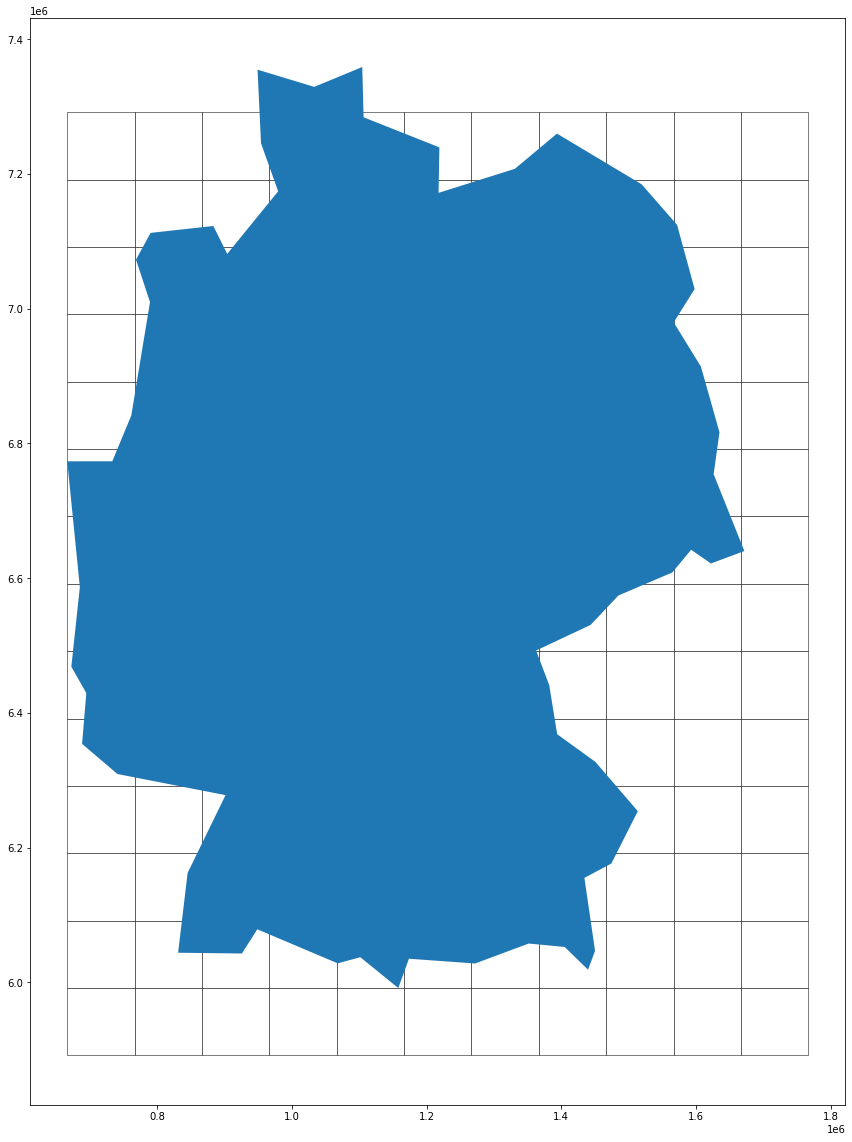

In [19]:
%%time

base = grid.plot(figsize=(15,20), color='white', edgecolor='black', linewidth=0.5)
# combine with world geometry
plot = de.plot(ax=base)

In [20]:
centroid_grid = grid.centroid.reset_index()
centroid_grid.set_index(["xbin", "ybin"], inplace=True)

centroid_grid = gpd.GeoDataFrame(
        grid.centroid)
centroid_grid.rename(
        columns={0:'geometry'},
        inplace=True)
centroid_grid.set_geometry(
        'geometry', crs=grid.crs, 
        inplace=True)
grid_intersect_de = gpd.sjoin(
        centroid_grid, de, 
        how='right')
grid_intersect_de.set_index(
        ["index_left0", "index_left1"],
        inplace=True)
grid_intersect_de.index.names = ['xbin','ybin']
grid_de = grid.loc[grid_intersect_de.index]

<AxesSubplot:>

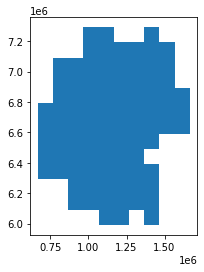

In [21]:
"""#ax = gplt.webmap(de,
                projection = gcrs.WebMercator(),
                provider = ctx.providers.Stamen.TonerLite,
                figsize = (35,20)
                )"""
grid_de.plot()

In [22]:
grid_join_de = gpd.sjoin(gdf.to_crs(epsg=3857),grid_de, how="right", op='within')
grid_join_de

index_left  latitude_3  longitude_3  usercount  postcount  \
xbin    ybin                                                                 
666654  6791588         NaN         NaN          NaN        NaN        NaN   
        6691588     83635.0   51.328125     6.328125        1.0        3.0   
        6691588     83384.0   51.328125     6.328125        1.0        1.0   
        6691588     83385.0   51.328125     6.328125        1.0        1.0   
        6691588     83386.0   51.328125     6.328125        1.0        1.0   
...                     ...         ...          ...        ...        ...   
1566654 6691588     87843.0   51.328125    14.765625        1.0        3.0   
        6691588     87865.0   51.328125    14.765625        1.0        2.0   
        6691588     87864.0   51.328125    14.765625        1.0        1.0   
        6691588     87863.0   51.328125    14.765625        1.0        1.0   
        6691588     87862.0   51.328125    14.765625        1.0        1.0   

                              hashtags  \
xbin    ybin                             
666654  6791588                    NaN   
        6691588          luilekkerland   
        6691588              inleiding   
        6691588         innenausschuss   
        6691588  innonazionaleitaliano   
...                                ...   
1566654 6691588                btw2017   
        6691588            istafberlin   
        6691588            immigration   
        6691588                   gysi   
        6691588              gutachten   

                                                          geometry  
xbin    ybin                                                        
666654  6791588  POLYGON ((666654.000 6791588.000, 766654.000 6...  
        6691588  POLYGON ((666654.000 6691588.000, 766654.000 6...  
        6691588  POLYGON ((666654.000 6691588.000, 766654.000 6...  
        6691588  POLYGON ((666654.000 6691588.000, 766654.000 6...  
        6691588  POLYGON ((666654.000 6691588.000, 766654.000 6...  
...                                                            ...  
1566654 6691588  POLYGON ((1566654.000 6691588.000, 1666654.000...  
        6691588  POLYGON ((1566654.000 6691588.000, 1666654.000...  
        6691588  POLYGON ((1566654.000 6691588.000, 1666654.000...  
        6691588  POLYGON ((1566654.000 6691588.000, 1666654.000...  
        6691588  POLYGON ((1566654.000 6691588.000, 1666654.000...  

[20798 rows x 7 columns]

In [31]:
#grid_join_de.drop(columns =["latitude_3","longitude_3","index_left"],inplace =True)
#grid_join_de.dropna(subset=["hashtags"],inplace =True)
grid_join_de['postcount'].max()


534.0

<AxesSubplot:>

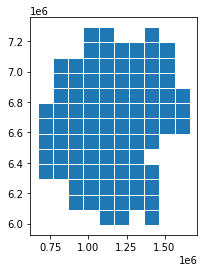

In [15]:
grid_join_de.plot(edgecolor= 'white')

<AxesSubplot:title={'center':'Grids in Germany'}>

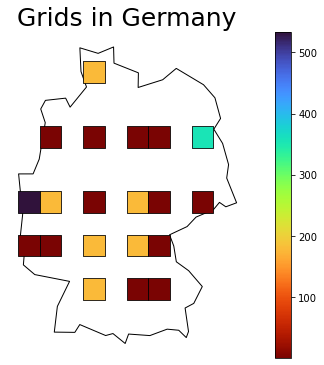

In [34]:
# set a variable that will call whatever column we want to visualise on the 
mapvariable = 'postcount'
# set the range for the choropleth
vmin, vmax = 1.0, 534.0
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis("off")
ax.set_title("Grids in Germany", fontdict={"fontsize": 25, "fontweight" : 3})
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="turbo_r", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data rangesm._
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
ax =grid_join_de[grid_join_de["hashtags"]=='merkel'].plot(column=mapvariable,
                                                      cmap= 'turbo_r',
                                                      linewidth=0.8, ax=ax,
                                                      edgecolor= 'black',
                                                      zorder =10,
                                                      scheme = 'headtail_breaks'    
                                                      
                                                     )
de.plot(ax = ax, facecolor ='white',edgecolor ='black')

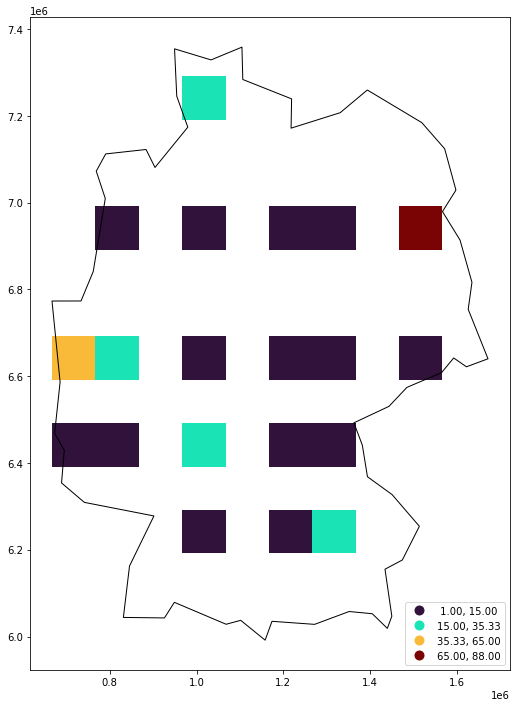

In [40]:
fig, ax = plt.subplots(1, 1,figsize=(10,12))

base = grid_join_de[grid_join_de["hashtags"]=='merkel'].plot(
        ax=ax, column='usercount', cmap='turbo', scheme='headtail_breaks', 
        legend=True, legend_kwds={'loc': 'lower right'}
)

plot = de.plot(
        ax=base, color='none', edgecolor='black', linewidth=1)
ax.get_legend()


In [27]:
grid_join_de.reset_index(inplace =True)
grid_join_de.set_index(['hashtags'],inplace =True)

In [47]:
type(grid_join_de.index[0])

float

In [56]:
grid_join_de['geometry'].count()

20798

In [26]:
grid_join_de.drop(columns =['index_left','latitude_3','longitude_3'],inplace =True)
grid_join_de

,xbin,ybin,usercount,postcount,hashtags
geometry,,,,,
"POLYGON ((666654 6791588, 766654 6791588, 766654 6691588, 666654 6691588, 666654 6791588))",666654,6791588,NaN,NaN,NaN
"POLYGON ((666654 6691588, 766654 6691588, 766654 6591588, 666654 6591588, 666654 6691588))",666654,6691588,1.0,3.0,luilekkerland
"POLYGON ((666654 6691588, 766654 6691588, 766654 6591588, 666654 6591588, 666654 6691588))",666654,6691588,1.0,1.0,inleiding
"POLYGON ((666654 6691588, 766654 6691588, 766654 6591588, 666654 6591588, 666654 6691588))",666654,6691588,1.0,1.0,innenausschuss
"POLYGON ((666654 6691588, 766654 6691588, 766654 6591588, 666654 6591588, 666654 6691588))",666654,6691588,1.0,1.0,innonazionaleitaliano
...,...,...,...,...,...
"POLYGON ((1566654 6691588, 1666654 6691588, 1666654 6591588, 1566654 6591588, 1566654 6691588))",1566654,6691588,1.0,3.0,btw2017
"POLYGON ((1566654 6691588, 1666654 6691588, 1666654 6591588, 1566654 6591588, 1566654 6691588))",1566654,6691588,1.0,2.0,istafberlin
"POLYGON ((1566654 6691588, 1666654 6691588, 1666654 6591588, 1566654 6591588, 1566654 6691588))",1566654,6691588,1.0,1.0,immigration
